In [2]:
#!conda install  -y -c conda-forge fsspec
import matplotlib.pyplot as mplot
import numpy
import os
import pandas
import random
import seaborn
import sys
import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Dodatkowe funkcje:
sys.path.append('tools')
import sound_tools
import utils
import rekognition_tools as rt

import boto3



In [3]:
%matplotlib inline
random.seed(42)
numpy.random.seed(42)
mplot.style.use('seaborn')

DATA           = os.path.join('data', 'temp')
PROCESSED_DATA = os.path.join('data', 'processed2')
TRAIN_PATH     = os.path.join(PROCESSED_DATA, 'train')
TEST_PATH      = os.path.join(PROCESSED_DATA, 'test')

os.makedirs(os.path.join(PROCESSED_DATA, 'train', 'normal'), exist_ok=True)
os.makedirs(os.path.join(PROCESSED_DATA, 'train', 'abnormal'), exist_ok=True)
os.makedirs(os.path.join(PROCESSED_DATA, 'test', 'normal'), exist_ok=True)
os.makedirs(os.path.join(PROCESSED_DATA, 'test', 'abnormal'), exist_ok=True)

In [4]:
import sys
sys.path.append('tools')
import rekognition_tools as rt
!python3 -V
n_mels = 128
frames = 5
n_fft = 2048
hop_length = 512
power = 2.0
blue = '#1520A6' #azure
red = '#ff1a1a'

Python 3.7.10


In [5]:
########budowa zbiorów danych

def build_files_list(root_dir, abnormal_dir='abnormal', normal_dir='normal'):
    normal_files = []
    abnormal_files = []
    for root, dirs, files in os.walk(top = os.path.join(root_dir)):
        for name in files:
            current_dir_type = root.split('/')[-1]
            if current_dir_type == abnormal_dir:
                abnormal_files.append(os.path.join(root, name))
            if current_dir_type == normal_dir:
                normal_files.append(os.path.join(root, name))
    return normal_files, abnormal_files

try:
    dataset = dict({
        'train_files': train_files,
        'test_files': test_files,
        'train_labels': train_labels,
        'test_labels': test_labels
    })

    for key in ['train_files', 'test_files', 'train_labels', 'test_labels']:
        fname = os.path.join(PROCESSED_DATA, key + '.txt')
        with open(fname, 'r') as f:
            dataset.update({
                key: [line[:-1] for line in f.readlines()]
            })

    dataset['train_labels'] = [numpy.float(label) for label in dataset['train_labels']]
    dataset['test_labels'] = [numpy.float(label) for label in dataset['test_labels']]
    
except Exception as e:
    normal_files, abnormal_files = build_files_list(root_dir=os.path.join(DATA, 'fan'))

    X = numpy.concatenate((normal_files, abnormal_files), axis=0)
    y = numpy.concatenate((numpy.zeros(len(normal_files)), numpy.ones(len(abnormal_files))), axis=0)
    print(X)
    train_files, test_files, train_labels, test_labels = train_test_split(X, y,
                                                                          train_size=0.85,
                                                                          random_state=508,
                                                                          shuffle=True,
                                                                          stratify=y
                                                                         )

['data/temp/fan/id_04/normal/00000719.wav'
 'data/temp/fan/id_04/normal/00000441.wav'
 'data/temp/fan/id_04/normal/00000925.wav' ...
 'data/temp/fan/id_02/abnormal/00000284.wav'
 'data/temp/fan/id_02/abnormal/00000100.wav'
 'data/temp/fan/id_02/abnormal/00000316.wav']


### Tworzenie spektorgramów Mela

In [6]:
print(train_files)
img_train_files = sound_tools.generate_spectrograms(train_files, os.path.join(PROCESSED_DATA, 'train'))
img_test_files = sound_tools.generate_spectrograms(test_files, os.path.join(PROCESSED_DATA, 'test'))

kkkk: 100%|██████████| 833/833 [00:00<00:00, 132922.02it/s]

['data/temp/fan/id_00/normal/00000217.wav'
 'data/temp/fan/id_02/normal/00000062.wav'
 'data/temp/fan/id_02/normal/00000015.wav' ...
 'data/temp/fan/id_00/abnormal/00000221.wav'
 'data/temp/fan/id_02/normal/00000768.wav'
 'data/temp/fan/id_06/normal/00000582.wav']


### Przygotowanie S3 bucketa

In [7]:

BUCKET = 'apdiplomalabels'
PREFIX = 'custom-label-2'
LABELS = ['abnormal', 'normal']

In [8]:
!aws s3 cp --recursive $TRAIN_PATH s3://$BUCKET/$PREFIX/train
!aws s3 cp --recursive $TEST_PATH s3://$BUCKET/$PREFIX/test

upload: data/processed2/train/abnormal/abnormal-id_00-00000006.png to s3://apdiplomalabels/custom-label-2/train/abnormal/abnormal-id_00-00000006.png
upload: data/processed2/train/abnormal/abnormal-id_00-00000003.png to s3://apdiplomalabels/custom-label-2/train/abnormal/abnormal-id_00-00000003.png
upload: data/processed2/train/abnormal/abnormal-id_00-00000010.png to s3://apdiplomalabels/custom-label-2/train/abnormal/abnormal-id_00-00000010.png
upload: data/processed2/train/abnormal/abnormal-id_00-00000000.png to s3://apdiplomalabels/custom-label-2/train/abnormal/abnormal-id_00-00000000.png
upload: data/processed2/train/abnormal/abnormal-id_00-00000005.png to s3://apdiplomalabels/custom-label-2/train/abnormal/abnormal-id_00-00000005.png
upload: data/processed2/train/abnormal/abnormal-id_00-00000004.png to s3://apdiplomalabels/custom-label-2/train/abnormal/abnormal-id_00-00000004.png
upload: data/processed2/train/abnormal/abnormal-id_00-00000009.png to s3://apdiplomalabels/custom-label-2/

In [8]:
rt.create_manifest_from_bucket(BUCKET, PREFIX, 'train', LABELS, output_bucket=f's3://{BUCKET}/{PREFIX}/manifests')
rt.create_manifest_from_bucket(BUCKET, PREFIX, 'test', LABELS, output_bucket=f's3://{BUCKET}/{PREFIX}/manifests')

## Tworzenie projektu Custom Labels

In [9]:
PROJECT_NAME = 'sound-anomaly-detection'
reko = boto3.client("rekognition")

In [10]:

try:
    project_arn = reko.create_project(ProjectName=PROJECT_NAME)['ProjectArn']
    
except reko.exceptions.ResourceInUseException:
    #jeśli projekt istnieje, to nie tworzymy nowego, tylko pobieramy stary
    print('Projekt już istnieje')
    reko_project_list = reko.describe_projects()
    
    for project in reko_project_list['ProjectDescriptions']:
        project_name = project['ProjectArn'].split('/')[1]
        
        if (project_name == PROJECT_NAME):
            project_arn = project['ProjectArn']
            break
            
project_arn

Projekt już istnieje


'arn:aws:rekognition:us-east-1:498219726579:project/sound-anomaly-detection/1650447887368'

## Powiązanie zbioru danych z projektem

In [11]:
TrainingData = {
    'Assets': [{ 
        'GroundTruthManifest': {
            'S3Object': { 
                'Bucket': BUCKET,
                'Name': f'{PREFIX}/manifests/train.manifest'
            }
        }
    }]
}

TestingData = {
    'AutoCreate': True
}

OutputConfig = { 
    'S3Bucket': BUCKET,
    'S3KeyPrefix': f'{PREFIX}/output'
}

In [12]:
version = 'experiment-1'
VERSION_NAME = f'{PROJECT_NAME}.{version}'

try:
    project_version_arn = reko.create_project_version(
        ProjectArn=project_arn,      
        VersionName=VERSION_NAME,    
        OutputConfig=OutputConfig,   # S3 lokalizacja wyjścia
        TrainingData=TrainingData,   # S3 lokalizacja pliku manifestu opisującego treningowe dane
        TestingData=TestingData      # S3 lokalizacja pliku manifestu opisującego testowe dane
    )['ProjectVersionArn']
    
# Jeśli już istnieje taka wersja projektu, to nie tworzymy go od nowa, tylko korzystamy z istniejącego
except reko.exceptions.ResourceInUseException:
    print('Wersja projektu już istnieje, szukam ARN:', end=' ')
    reko_project_versions_list = reko.describe_project_versions(ProjectArn=project_arn)
    
    for project_version in reko_project_versions_list['ProjectVersionDescriptions']:
        project_version_name = project_version['ProjectVersionArn'].split('/')[3]

        if (project_version_name == VERSION_NAME):
            project_version_arn = project_version['ProjectVersionArn']
            break
            
print(project_version_arn)
status = reko.describe_project_versions(
    ProjectArn=project_arn,
    VersionNames=[project_version_arn.split('/')[3]]
)['ProjectVersionDescriptions'][0]['Status']

Wersja projektu już istnieje, szukam ARN: arn:aws:rekognition:us-east-1:498219726579:project/sound-anomaly-detection/version/sound-anomaly-detection.experiment-1/1650447902211


In [13]:
# Czekanie aż skończy się trening
while status == 'TRAINING_IN_PROGRESS':
    status = reko.describe_project_versions(
        ProjectArn=project_arn,
        VersionNames=[project_version_arn.split('/')[3]]
    )['ProjectVersionDescriptions'][0]['Status']

    print(status)
    time.sleep(60)
    
print(status)

RUNNING


## Startowanie modelu

In [14]:
rt.start_model(project_arn, project_version_arn, VERSION_NAME)

Startowanie modelu: arn:aws:rekognition:us-east-1:498219726579:project/sound-anomaly-detection/version/sound-anomaly-detection.experiment-1/1650447902211
An error occurred (ResourceInUseException) when calling the StartProjectVersion operation: ProjectVersion arn:aws:rekognition:us-east-1:498219726579:project/sound-anomaly-detection/version/sound-anomaly-detection.experiment-1/1650447902211 is RUNNING; cannot be started


## Ewaluacja modelu
## Sprawdzenie wyników osiąganych przez system na zbiorze testowym 

In [15]:
import s3fs

test_results_filename = os.path.join(PROCESSED_DATA, f'results_rekognition_{PROJECT_NAME}-{version}.csv')

predictions_ok = rt.get_results(project_version_arn, BUCKET, s3_path=f'{BUCKET}/{PREFIX}/test/normal', label='normal', verbose=True)
predictions_ko = rt.get_results(project_version_arn, BUCKET, s3_path=f'{BUCKET}/{PREFIX}/test/abnormal', label='abnormal', verbose=True)

test_predictions = pandas.concat([predictions_ok, predictions_ko], axis='index')
test_predictions = rt.reshape_results(test_predictions)
test_predictions.to_csv(test_results_filename, index=None)

Looking for test results file: "data/processed2/results_rekognition_sound-anomaly-detection-experiment-1.csv"
Predictions file on the test dataset does not exist, querying the endpoint to collect inference results...
....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|................................................................................................................|................................................................

### Confusion matrix analysis

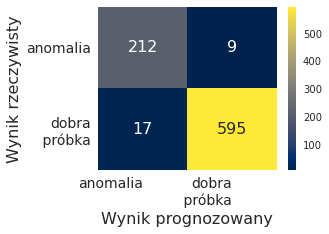

In [17]:
def generate_error_types(df, ground_truth_col='Ground Truth', prediction_col='Prediction', normal_label=0.0, anomaly_label=1.0):
    df['TP'] = 0
    df['TN'] = 0
    df['FP'] = 0
    df['FN'] = 0
    df.loc[(df[ground_truth_col] == df[prediction_col]) & (df[ground_truth_col] == normal_label), 'TP'] = 1
    df.loc[(df[ground_truth_col] == df[prediction_col]) & (df[ground_truth_col] == anomaly_label), 'TN'] = 1
    df.loc[(df[ground_truth_col] != df[prediction_col]) & (df[ground_truth_col] == normal_label), 'FP'] = 1
    df.loc[(df[ground_truth_col] != df[prediction_col]) & (df[ground_truth_col] == anomaly_label), 'FN'] = 1
    return df

df = generate_error_types(test_predictions, normal_label='normal', anomaly_label='abnormal')
tp = df['TP'].sum()
tn = df['TN'].sum()
fn = df['FN'].sum()
fp = df['FP'].sum()

def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=14):
    df_cm = pandas.DataFrame(confusion_matrix, 
                         index=class_names, 
                         columns=class_names)
    
    fig = mplot.figure(figsize=figsize)
    try:
        heatmap = seaborn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}, cmap='cividis')
    except ValueError:
        raise ValueError("input ints")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    mplot.ylabel('Wynik rzeczywisty', fontsize=16)
    mplot.xlabel('Wynik prognozowany', fontsize=16)
    
    return fig

print_confusion_matrix(confusion_matrix(df['Ground Truth'], df['Prediction']), class_names=['anomalia', 'dobra\n próbka']);

In [18]:
### obliczanie wskaźników
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * precision * recall / (precision + recall)
miss_rate = fn / (tp + fn)
print(f"""Podstawowe wskaźniki kwalifikacji wyników:
- precyzja: {precision*100:.1f}%
- czułość: {recall*100:.1f}%
- dokładność: {accuracy*100:.1f}%
- wynik F1: {f1_score*100:.1f}%
- fałszywie ujemne: {miss_rate*100:.1f}%""")

Podstawowe wskaźniki kwalifikacji wyników:
- precyzja: 97.2%
- czułość: 98.5%
- dokładność: 96.9%
- wynik F1: 97.9%
- fałszywie ujemne: 1.5%


In [19]:
### usuwanie endpointu w celu oszczędności środków
rt.stop_model(project_version_arn)

Stopping model:arn:aws:rekognition:us-east-1:498219726579:project/sound-anomaly-detection/version/sound-anomaly-detection.experiment-1/1650447902211
Status: STOPPING
